In [48]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import time
import re
from datetime import datetime
from collections import Counter

search_map = {
    "IT_SW": "백엔드 개발",
    "금융_물류": "재무 회계",
    "디자인": "웹 디자인 UI/UX",
    "영상_광고": "영상 편집 콘텐츠",
    "경영_글로벌": "해외 영업 기획",
    "공공_행정": "총무 사무 행정",
    "뷰티_예술": "브랜드 마케팅"
}

target_tools = {
    "Gen_AI": [
        "ChatGPT", "GPT", "Copilot", "Cursor", "Gemini", "Perplexity", "Claude",
        "Midjourney", "Stable Diffusion", "Firefly", "Notion AI", "DALL-E",
        "Wrtn", "뤼튼", "생성형", "AI 활용", "AI 툴", "LLM", "생성형 AI",
        "프롬프트", "Prompt", "AI 에이전트", "ChatBot", "챗봇"
    ],
    "Foundation": [
        "Python", "파이썬", "SQL", "Data", "데이터", "AWS", "Git", "Docker",
        "Tableau", "태블로", "GA4", "SAP", "ERP", "Java", "자바",
        "Figma", "피그마", "Photoshop", "포토샵", "Premiere", "프리미어",
        "AutoCAD", "캐드", "Excel", "엑셀", "PowerPoint", "PPT", "OA",
        "R", "Pandas", "Jupyter", "JavaScript", "React", "Vue",
        "Spring", "Django", "Flask", "Kubernetes", "Linux",
        "Illustrator", "일러스트", "InDesign", "After Effects", "에펙",
        "Jira", "Confluence", "Slack", "Notion", "TensorFlow", "PyTorch",
        "Keras", "Scikit-learn", "NumPy", "Matplotlib", "Seaborn"
    ]
}

def analyze_tools(text):
    if not text:
        return {"Gen_AI": 0, "Foundation": 0, "Gen_AI_tools": [], "Foundation_tools": []}
    
    text_upper = text.upper()
    results = {"Gen_AI": 0, "Foundation": 0, "Gen_AI_tools": [], "Foundation_tools": []}
    
    for category, keywords in target_tools.items():
        found_tools = []
        for keyword in keywords:
            pattern = re.escape(keyword.upper())
            if re.search(pattern, text_upper):
                found_tools.append(keyword)
        
        if category == "Gen_AI":
            results["Gen_AI"] = len(found_tools)
            results["Gen_AI_tools"] = list(set(found_tools))
        else:
            results["Foundation"] = len(found_tools)
            results["Foundation_tools"] = list(set(found_tools))
    
    return results

def crawl_saramin(field_name, search_keyword, max_count=100):
    driver = webdriver.Chrome()
    wait = WebDriverWait(driver, 15)
    results = []
    
    try:
        search_url = f"https://www.saramin.co.kr/zf_user/search/recruit?searchType=search&searchword={search_keyword}&recruitPage=1&recruitSort=relation&recruitPageCount=40"
        driver.get(search_url)
        time.sleep(3)
        
        try:
            recruit_tab = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(text(), '채용정보')]")))
            driver.execute_script("arguments[0].click();", recruit_tab)
            time.sleep(3)
        except:
            pass
        
        collected = 0
        page = 1
        max_pages = 10
        
        while collected < max_count and page <= max_pages:
            try:
                job_items = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".item_recruit")))
                
                if len(job_items) == 0:
                    break
                
                for idx, item in enumerate(job_items):
                    if collected >= max_count:
                        break
                    
                    try:
                        title_elem = item.find_element(By.CSS_SELECTOR, ".job_tit a")
                        title = title_elem.text.strip()
                        link = title_elem.get_attribute("href")
                        
                        company_elem = item.find_element(By.CSS_SELECTOR, ".corp_name a")
                        company = company_elem.text.strip()
                        
                        if not title or not company:
                            continue
                        
                        driver.execute_script("window.open(arguments[0]);", link)
                        driver.switch_to.window(driver.window_handles[-1])
                        time.sleep(3)
                        
                        # 상세 페이지 제한적 스크롤 (3회)
                        for _ in range(3):
                            driver.execute_script("window.scrollBy(0, 800);")
                            time.sleep(0.8)
                        
                        driver.execute_script("window.scrollTo(0, 0);")
                        time.sleep(0.5)
                        
                        detail_content = ""
                        try:
                            iframe = driver.find_element(By.ID, "iframe_content_0")
                            driver.switch_to.frame(iframe)
                            
                            # iframe 내부 제한적 스크롤 (3회)
                            for _ in range(3):
                                driver.execute_script("window.scrollBy(0, 800);")
                                time.sleep(0.8)
                            
                            detail_content = driver.find_element(By.TAG_NAME, "body").text
                            driver.switch_to.default_content()
                        except:
                            try:
                                content_elem = driver.find_element(By.CSS_SELECTOR, ".wrap_jview")
                                detail_content = content_elem.text
                            except:
                                detail_content = driver.find_element(By.TAG_NAME, "body").text
                        
                        tool_counts = analyze_tools(detail_content)
                        
                        results.append({
                            "분야": field_name,
                            "검색어": search_keyword,
                            "회사명": company,
                            "직무명": title,
                            "Gen_AI 언급수": tool_counts["Gen_AI"],
                            "Foundation 언급수": tool_counts["Foundation"],
                            "Gen_AI 툴": ", ".join(tool_counts["Gen_AI_tools"]),
                            "Foundation 툴": ", ".join(tool_counts["Foundation_tools"]),
                            "링크": link
                        })
                        
                        collected += 1
                        
                    except Exception as e:
                        pass
                    finally:
                        if len(driver.window_handles) > 1:
                            driver.close()
                            driver.switch_to.window(driver.window_handles[0])
                        time.sleep(1.5)
                
                if collected >= max_count:
                    break
                
                page += 1
                if page <= max_pages:
                    try:
                        next_page_url = f"https://www.saramin.co.kr/zf_user/search/recruit?searchType=search&searchword={search_keyword}&recruitPage={page}&recruitSort=relation&recruitPageCount=40"
                        driver.get(next_page_url)
                        time.sleep(3)
                    except:
                        break
                else:
                    break
                    
            except TimeoutException:
                break
            except Exception as e:
                break
                
    except Exception as e:
        pass
    finally:
        try:
            driver.quit()
        except:
            pass
    
    return results

start_time = datetime.now()
print("=" * 80)
print("사람인 채용공고 AI 툴 분석 시작")
print(f"시작 시간: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

all_results = []

for idx, (field_code, keyword) in enumerate(search_map.items(), 1):
    print(f"\n[{idx}/{len(search_map)}] {field_code} - '{keyword}' 크롤링 시작...")
    field_results = crawl_saramin(field_code, keyword, max_count=100)
    all_results.extend(field_results)
    print(f"✓ {field_code} 완료: {len(field_results)}건 수집")
    time.sleep(5)

df_detailed = pd.DataFrame(all_results)
df_model = df_detailed.copy()

field_encoding = {
    "IT_SW": 0,
    "금융_물류": 1,
    "디자인": 2,
    "영상_광고": 3,
    "경영_글로벌": 4,
    "공공_행정": 5,
    "뷰티_예술": 6
}
df_model['분야_코드'] = df_model['분야'].map(field_encoding)
df_model['Gen_AI_활용여부'] = (df_model['Gen_AI 언급수'] > 0).astype(int)
df_model['Foundation_활용여부'] = (df_model['Foundation 언급수'] > 0).astype(int)
df_model['AI_툴_종합활용여부'] = ((df_model['Gen_AI 언급수'] > 0) | (df_model['Foundation 언급수'] > 0)).astype(int)

def categorize_usage(count):
    if count == 0:
        return 0
    elif count <= 2:
        return 1
    elif count <= 5:
        return 2
    else:
        return 3

df_model['Gen_AI_활용수준'] = df_model['Gen_AI 언급수'].apply(categorize_usage)
df_model['Foundation_활용수준'] = df_model['Foundation 언급수'].apply(categorize_usage)
df_model['Gen_AI_비율'] = df_model['Gen_AI 언급수'] / (df_model['Gen_AI 언급수'] + df_model['Foundation 언급수'] + 0.001)
df_model['Foundation_비율'] = df_model['Foundation 언급수'] / (df_model['Gen_AI 언급수'] + df_model['Foundation 언급수'] + 0.001)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
detailed_filename = f"saramin_detailed_{timestamp}.csv"
df_detailed.to_csv(detailed_filename, index=False, encoding="utf-8-sig")

model_filename = f"saramin_model_{timestamp}.csv"
model_columns = [
    '분야', '분야_코드', '검색어', '회사명', '직무명',
    'Gen_AI 언급수', 'Foundation 언급수',
    'Gen_AI_활용여부', 'Foundation_활용여부', 'AI_툴_종합활용여부',
    'Gen_AI_활용수준', 'Foundation_활용수준',
    'Gen_AI_비율', 'Foundation_비율',
    '링크'
]
df_model[model_columns].to_csv(model_filename, index=False, encoding="utf-8-sig")

end_time = datetime.now()
elapsed_time = end_time - start_time

print("\n" + "=" * 80)
print("분석 완료!")
print(f"종료 시간: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"소요 시간: {elapsed_time}")
print(f"총 수집 건수: {len(all_results)}건")
print(f"상세 데이터: {detailed_filename}")
print(f"모델 분석용 데이터: {model_filename}")
print("=" * 80)

if len(all_results) > 0:
    print("\n" + "=" * 80)
    print("분야별 요약 통계")
    print("=" * 80)
    
    summary = df_detailed.groupby("분야").agg({
        "Gen_AI 언급수": ["sum", "mean", "max"],
        "Foundation 언급수": ["sum", "mean", "max"]
    }).round(2)
    print(summary)
    
    print("\n" + "=" * 80)
    print("분야별 AI 툴 활용률")
    print("=" * 80)
    
    usage_rate = df_model.groupby("분야").agg({
        "Gen_AI_활용여부": "mean",
        "Foundation_활용여부": "mean",
        "AI_툴_종합활용여부": "mean"
    }).round(3) * 100
    usage_rate.columns = ["Gen_AI 활용률(%)", "Foundation 활용률(%)", "종합 활용률(%)"]
    print(usage_rate)
    
    print("\n" + "=" * 80)
    print("가장 많이 언급된 Gen_AI 툴 TOP 10")
    print("=" * 80)
    
    all_gen_ai_tools = []
    for tools in df_detailed["Gen_AI 툴"]:
        if tools:
            all_gen_ai_tools.extend([t.strip() for t in tools.split(",")])
    
    gen_ai_counter = Counter(all_gen_ai_tools)
    for tool, count in gen_ai_counter.most_common(10):
        print(f"{tool}: {count}건")
    
    print("\n" + "=" * 80)
    print("가장 많이 언급된 Foundation 툴 TOP 10")
    print("=" * 80)
    
    all_foundation_tools = []
    for tools in df_detailed["Foundation 툴"]:
        if tools:
            all_foundation_tools.extend([t.strip() for t in tools.split(",")])
    
    foundation_counter = Counter(all_foundation_tools)
    for tool, count in foundation_counter.most_common(10):
        print(f"{tool}: {count}건")


사람인 채용공고 AI 툴 분석 시작
시작 시간: 2025-12-13 01:30:21

[1/7] IT_SW - '백엔드 개발' 크롤링 시작...
✓ IT_SW 완료: 100건 수집

[2/7] 금융_물류 - '재무 회계' 크롤링 시작...
✓ 금융_물류 완료: 100건 수집

[3/7] 디자인 - '웹 디자인 UI/UX' 크롤링 시작...
✓ 디자인 완료: 100건 수집

[4/7] 영상_광고 - '영상 편집 콘텐츠' 크롤링 시작...
✓ 영상_광고 완료: 100건 수집

[5/7] 경영_글로벌 - '해외 영업 기획' 크롤링 시작...
✓ 경영_글로벌 완료: 100건 수집

[6/7] 공공_행정 - '총무 사무 행정' 크롤링 시작...
✓ 공공_행정 완료: 100건 수집

[7/7] 뷰티_예술 - '브랜드 마케팅' 크롤링 시작...
✓ 뷰티_예술 완료: 100건 수집

분석 완료!
종료 시간: 2025-12-13 03:30:40
소요 시간: 2:00:18.361953
총 수집 건수: 700건
상세 데이터: saramin_detailed_20251213_033040.csv
모델 분석용 데이터: saramin_model_20251213_033040.csv

분야별 요약 통계
       Gen_AI 언급수           Foundation 언급수          
              sum  mean max            sum  mean max
분야                                                  
IT_SW          29  0.29   4            640  6.40  14
경영_글로벌         11  0.11   5            118  1.18  14
공공_행정           3  0.03   1            103  1.03   4
금융_물류           0  0.00   0            140  1.40   6
디자인             8  0.

데이터: 700개 채용공고
유효: 398개

[상위 30개 키워드]
 1. 데이터             : 152회
 2. SQL             :  76회
 3. Java            :  72회
 4. ERP             :  58회
 5. AWS             :  52회
 6. 엑셀              :  50회
 7. Spring          :  49회
 8. Git             :  49회
 9. OA              :  37회
10. 포토샵             :  37회
11. Docker          :  36회
12. Python          :  36회
13. Linux           :  30회
14. Excel           :  30회
15. Photoshop       :  30회
16. Kubernetes      :  29회
17. Figma           :  29회
18. 프리미어            :  22회
19. SAP             :  20회
20. Illustrator     :  20회
21. Data            :  18회
22. AI              :  17회
23. PPT             :  17회
24. JavaScript      :  16회
25. 일러스트            :  15회
26. React           :  14회
27. Vue             :  12회
28. 생성형             :  12회
29. After           :  11회
30. Effects         :  11회


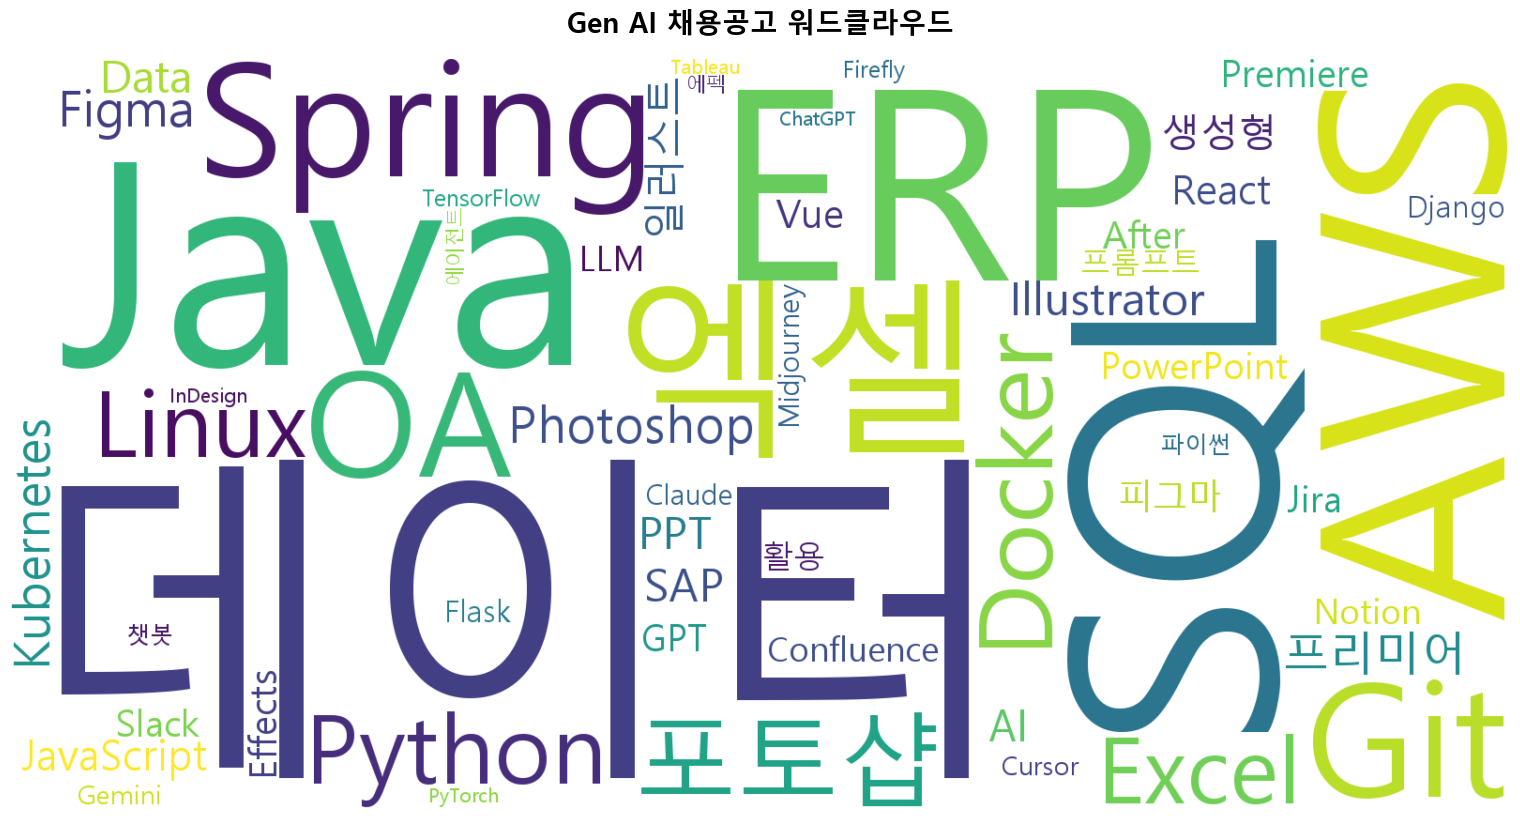

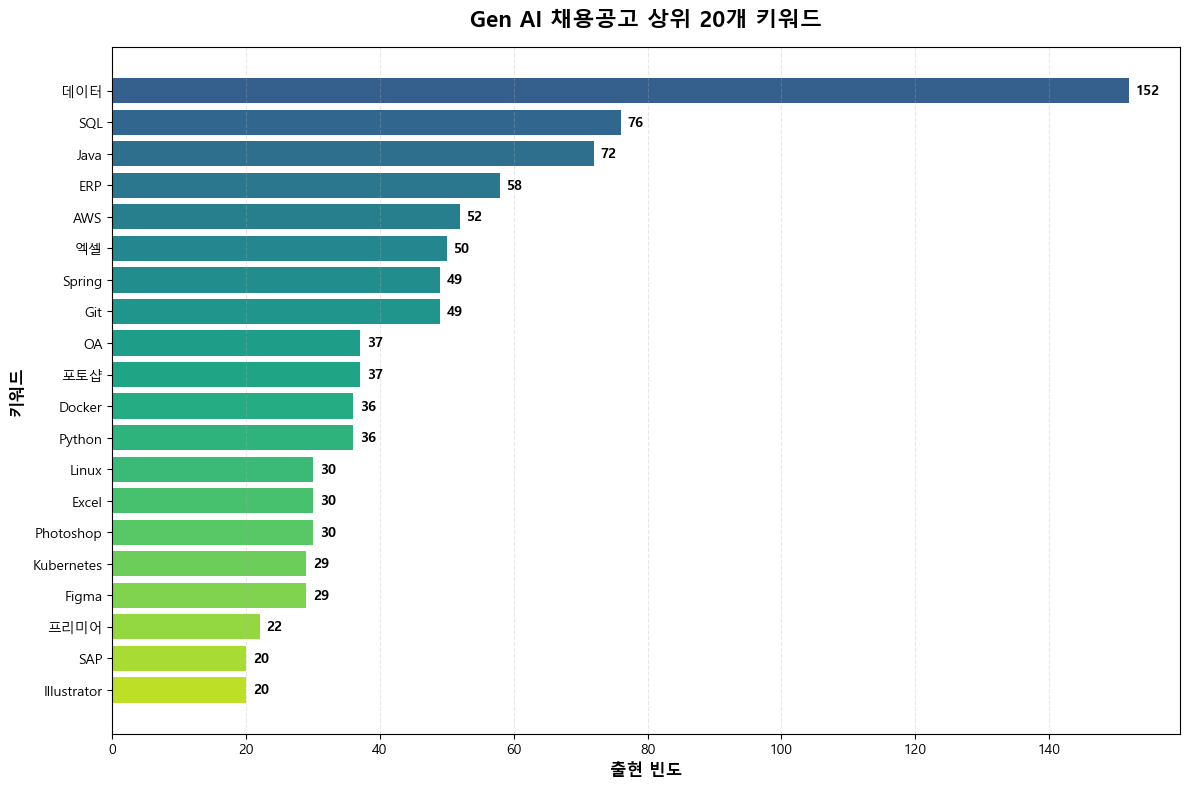


[TF-IDF 상위 20개]
 1. 데이터             :    68.28
 2. erp             :    37.06
 3. 엑셀              :    35.73
 4. java            :    27.35
 5. sql             :    24.18
 6. 포토샵             :    22.62
 7. oa              :    20.73
 8. spring          :    19.44
 9. figma           :    19.08
10. aws             :    18.56
11. excel           :    17.64
12. git             :    17.33
13. 프리미어            :    16.90
14. photoshop       :    15.55
15. python          :    13.86
16. sap             :    13.56
17. docker          :    13.23
18. linux           :    12.18
19. kubernetes      :    11.12
20. illustrator     :    10.36


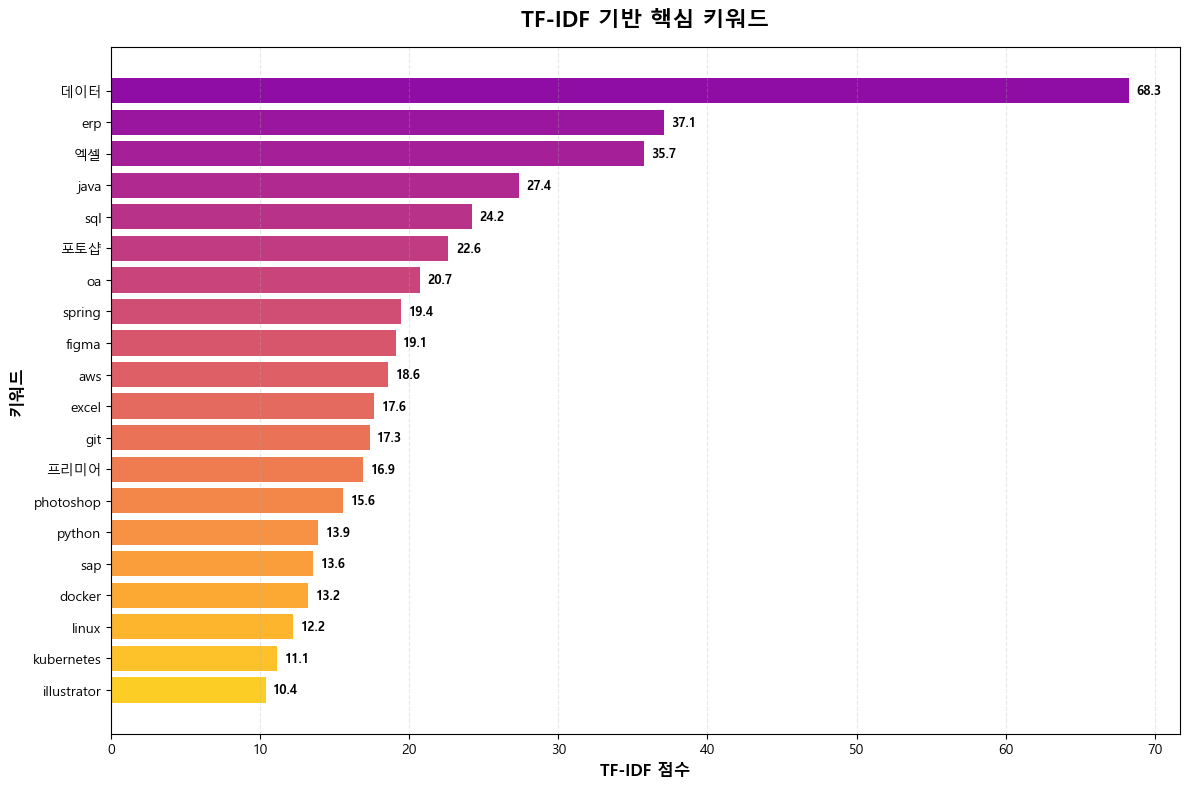


완료
- wordcloud.png
- top_keywords_chart.png
- tfidf_keywords_chart.png
- keyword_frequency_top30.csv
- tfidf_keywords_top20.csv
- analysis_summary.csv


In [69]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
file_path = r"C:\Users\pc\saramin_detailed_20251213_033040.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')
print(f"데이터: {len(df)}개 채용공고")

df['combined_text'] = df['Gen_AI 툴'].fillna('') + ' ' + df['Foundation 툴'].fillna('')
df = df[df['combined_text'].str.strip() != ''].reset_index(drop=True)
print(f"유효: {len(df)}개\n")

# 토큰화
def simple_tokenize(text):
    if pd.isna(text) or text.strip() == '':
        return []
    words = re.findall(r'[가-힣A-Za-z0-9]+', str(text))
    return [word for word in words if len(word) >= 2 and (re.search(r'[가-힣]', word) or word.isalpha())]

df['keywords'] = df['combined_text'].apply(simple_tokenize)

# 키워드 빈도
all_keywords = []
for keywords in df['keywords']:
    all_keywords.extend(keywords)

keyword_counter = Counter(all_keywords)
top_30_keywords = keyword_counter.most_common(30)

print("[상위 30개 키워드]")
for i, (keyword, count) in enumerate(top_30_keywords, 1):
    print(f"{i:2d}. {keyword:15s} : {count:3d}회")

# 워드클라우드
font_path = 'C:/Windows/Fonts/malgun.ttf'
keyword_dict = dict(keyword_counter)

wordcloud = WordCloud(
    font_path=font_path,
    width=1600,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=100,
    relative_scaling=0.3,
    min_font_size=10
).generate_from_frequencies(keyword_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Gen AI 채용공고 워드클라우드', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 상위 키워드 차트
top_20_keywords = keyword_counter.most_common(20)
keywords_df = pd.DataFrame(top_20_keywords, columns=['키워드', '빈도'])

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(keywords_df)), keywords_df['빈도'], 
                color=plt.cm.viridis(np.linspace(0.3, 0.9, len(keywords_df))))
plt.yticks(range(len(keywords_df)), keywords_df['키워드'])
plt.xlabel('출현 빈도', fontsize=12, fontweight='bold')
plt.ylabel('키워드', fontsize=12, fontweight='bold')
plt.title('Gen AI 채용공고 상위 20개 키워드', fontsize=16, fontweight='bold', pad=15)
plt.gca().invert_yaxis()

for i, (bar, value) in enumerate(zip(bars, keywords_df['빈도'])):
    plt.text(value + 1, i, str(value), va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('top_keywords_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# TF-IDF
df['keywords_text'] = df['keywords'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(max_features=50, min_df=2, token_pattern=r'[가-힣A-Za-z0-9]+')
tfidf_matrix = tfidf.fit_transform(df['keywords_text'])

feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_dict = dict(zip(feature_names, tfidf_scores))

sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]

print("\n[TF-IDF 상위 20개]")
for i, (keyword, score) in enumerate(sorted_tfidf, 1):
    print(f"{i:2d}. {keyword:15s} : {score:8.2f}")

# TF-IDF 차트
tfidf_df = pd.DataFrame(sorted_tfidf, columns=['키워드', 'TF-IDF 점수'])

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(tfidf_df)), tfidf_df['TF-IDF 점수'], 
                color=plt.cm.plasma(np.linspace(0.3, 0.9, len(tfidf_df))))
plt.yticks(range(len(tfidf_df)), tfidf_df['키워드'])
plt.xlabel('TF-IDF 점수', fontsize=12, fontweight='bold')
plt.ylabel('키워드', fontsize=12, fontweight='bold')
plt.title('TF-IDF 기반 핵심 키워드', fontsize=16, fontweight='bold', pad=15)
plt.gca().invert_yaxis()

for i, (bar, value) in enumerate(zip(bars, tfidf_df['TF-IDF 점수'])):
    plt.text(value + 0.5, i, f'{value:.1f}', va='center', fontsize=9, fontweight='bold')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('tfidf_keywords_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 결과 저장
top30_df = pd.DataFrame(top_30_keywords, columns=['키워드', '빈도'])
top30_df.to_csv('keyword_frequency_top30.csv', index=False, encoding='utf-8-sig')

tfidf_df.to_csv('tfidf_keywords_top20.csv', index=False, encoding='utf-8-sig')

summary_data = {
    '분석 항목': ['총 채용공고 수', '유효 데이터 수', '추출된 고유 키워드 수', '총 키워드 출현 횟수'],
    '값': [len(pd.read_csv(file_path, encoding='utf-8-sig')), 
           len(df), 
           len(keyword_counter), 
           sum(keyword_counter.values())]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('analysis_summary.csv', index=False, encoding='utf-8-sig')

print("\n완료")
print("- wordcloud.png")
print("- top_keywords_chart.png")
print("- tfidf_keywords_chart.png")
print("- keyword_frequency_top30.csv")
print("- tfidf_keywords_top20.csv")
print("- analysis_summary.csv")


데이터: 700개
유효: 398개

TF-IDF 행렬: (398, 51)

[Elbow Method]
K=2: Inertia=270.94, Silhouette=0.138
K=3: Inertia=246.66, Silhouette=0.176
K=4: Inertia=223.30, Silhouette=0.216
K=5: Inertia=208.42, Silhouette=0.247
K=6: Inertia=190.71, Silhouette=0.267
K=7: Inertia=182.54, Silhouette=0.273
K=8: Inertia=166.55, Silhouette=0.310
K=9: Inertia=158.37, Silhouette=0.330
K=10: Inertia=151.37, Silhouette=0.351


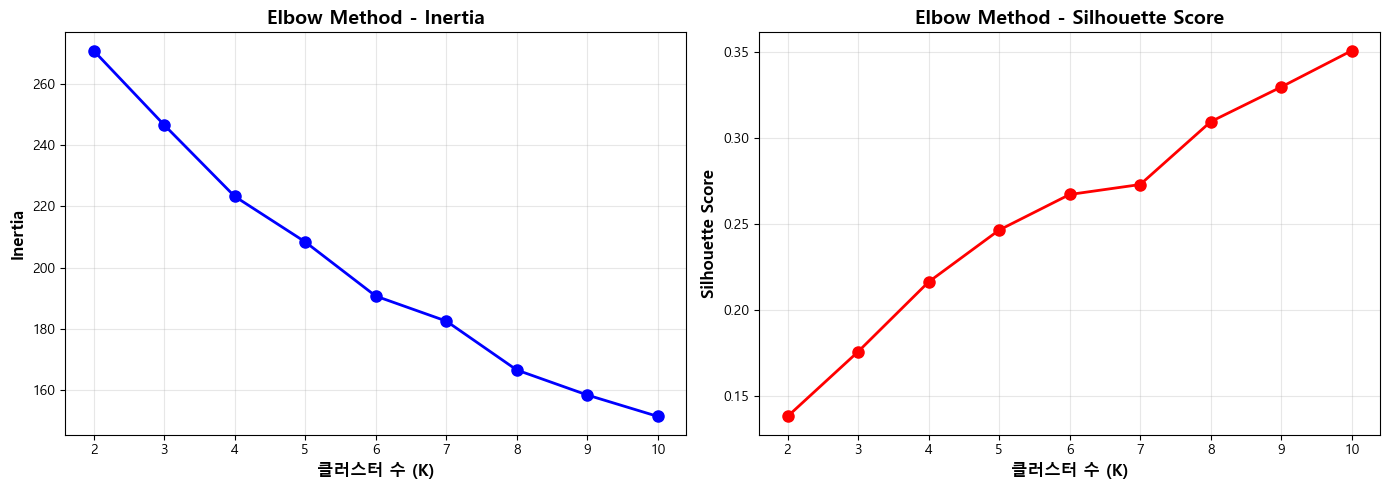


최적 클러스터 수: 10

[클러스터 분포]
클러스터 0: 86개 (21.6%)
클러스터 1: 17개 (4.3%)
클러스터 2: 123개 (30.9%)
클러스터 3: 32개 (8.0%)
클러스터 4: 31개 (7.8%)
클러스터 5: 15개 (3.8%)
클러스터 6: 29개 (7.3%)
클러스터 7: 19개 (4.8%)
클러스터 8: 26개 (6.5%)
클러스터 9: 20개 (5.0%)

PCA 설명 분산: 0.123, 0.101
총 설명 분산: 0.224



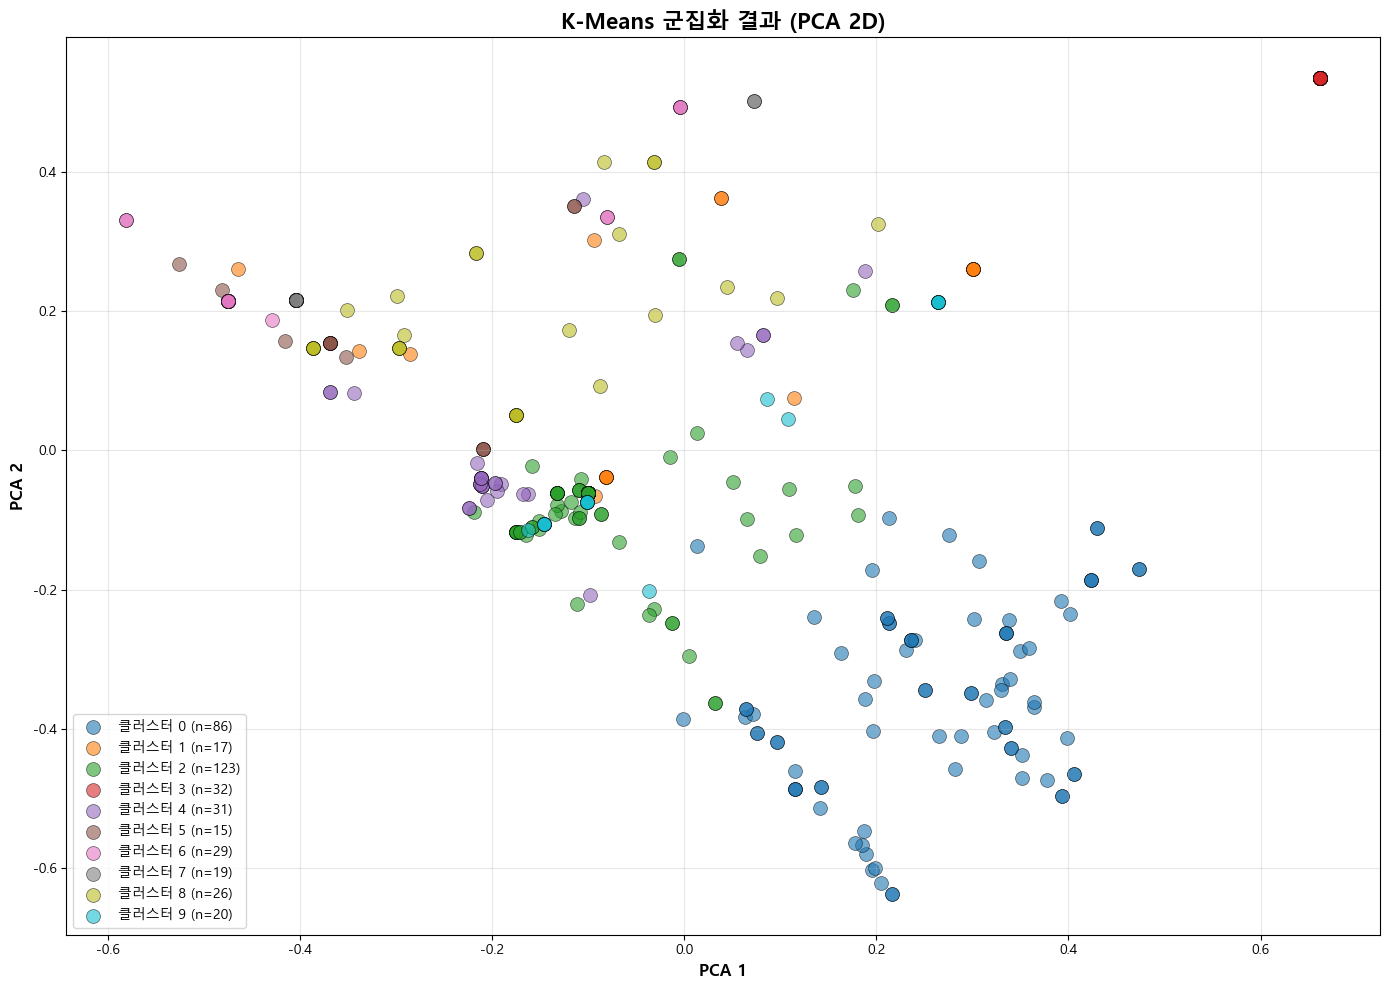

[클러스터별 대표 키워드 (상위 10개)]

클러스터 0 (86개):
  SQL(70), Java(66), 데이터(61), AWS(49), Spring(45), Git(42), Docker(34), Python(31), Linux(29), Kubernetes(26)

클러스터 1 (17개):
  OA(17), 데이터(9), ERP(4), 엑셀(3), Notion(1), Slack(1), GPT(1), 포토샵(1)

클러스터 2 (123개):
  Photoshop(18), 데이터(15), AI(15), Illustrator(14), 생성형(12), After(11), Effects(11), Premiere(11), 프리미어(10), React(8)

클러스터 3 (32개):
  데이터(32)

클러스터 4 (31개):
  포토샵(30), 일러스트(13), 프리미어(10), 데이터(6), PPT(4), 엑셀(3), Photoshop(2), 피그마(1), JavaScript(1), Java(1)

클러스터 5 (15개):
  SAP(15), ERP(10), 엑셀(4), Excel(2), 데이터(2), PPT(1), Tableau(1), OA(1)

클러스터 6 (29개):
  엑셀(29), 데이터(5), ERP(3), PPT(2), GPT(1)

클러스터 7 (19개):
  ERP(19), 데이터(2)

클러스터 8 (26개):
  Excel(26), ERP(15), 데이터(13), PowerPoint(9), 엑셀(8), PPT(6), 포토샵(5), OA(4), SAP(4), Illustrator(3)

클러스터 9 (20개):
  Figma(20), Photoshop(7), 데이터(7), Illustrator(1), Git(1), AI(1), 피그마(1), Jira(1), Confluence(1)



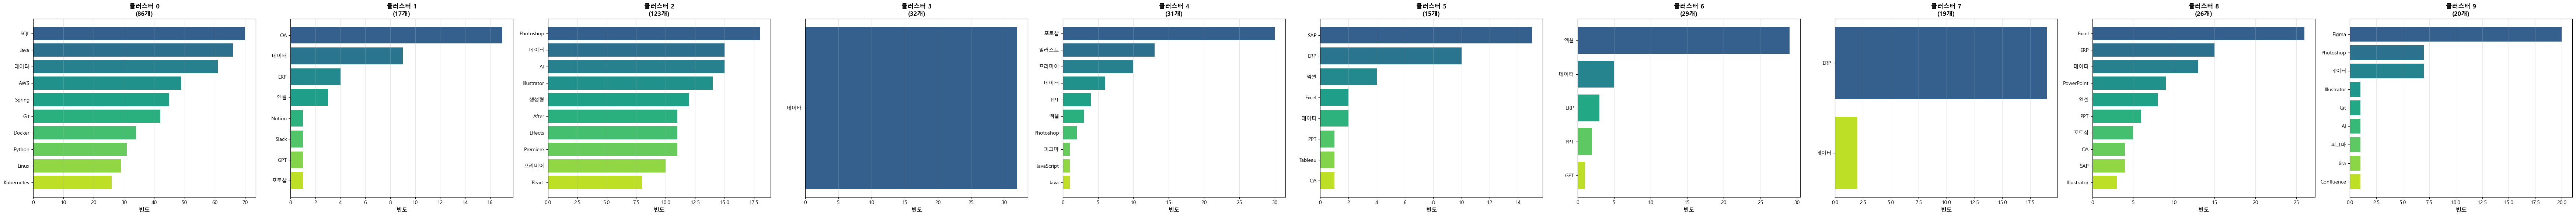

완료
- elbow_method.png
- clustering_visualization.png
- cluster_keywords_comparison.png
- cluster_summary.csv
- cluster_keywords.csv
- clustering_results.csv


In [70]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
file_path = r"C:\Users\pc\saramin_detailed_20251213_033040.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')
print(f"데이터: {len(df)}개")

df['combined_text'] = df['Gen_AI 툴'].fillna('') + ' ' + df['Foundation 툴'].fillna('')
df = df[df['combined_text'].str.strip() != ''].reset_index(drop=True)
print(f"유효: {len(df)}개\n")

# 토큰화
def simple_tokenize(text):
    if pd.isna(text) or text.strip() == '':
        return []
    words = re.findall(r'[가-힣A-Za-z0-9]+', str(text))
    return [word for word in words if len(word) >= 2 and (re.search(r'[가-힣]', word) or word.isalpha())]

df['keywords'] = df['combined_text'].apply(simple_tokenize)
df['keywords_text'] = df['keywords'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=100, min_df=2, token_pattern=r'[가-힣A-Za-z0-9]+')
tfidf_matrix = tfidf.fit_transform(df['keywords_text'])
print(f"TF-IDF 행렬: {tfidf_matrix.shape}\n")

# Elbow Method
print("[Elbow Method]")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Elbow 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('클러스터 수 (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('클러스터 수 (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Elbow Method - Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

# 최적 K 결정 (Silhouette 기준)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n최적 클러스터 수: {optimal_k}\n")

# K-Means 군집화
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(f"[클러스터 분포]")
for i in range(optimal_k):
    count = (df['cluster'] == i).sum()
    print(f"클러스터 {i}: {count}개 ({count/len(df)*100:.1f}%)")

# PCA 2D 시각화
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

print(f"\nPCA 설명 분산: {pca.explained_variance_ratio_[0]:.3f}, {pca.explained_variance_ratio_[1]:.3f}")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_):.3f}\n")

# 군집화 시각화
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_data = df[df['cluster'] == i]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], 
                c=[colors[i]], label=f'클러스터 {i} (n={len(cluster_data)})',
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

plt.xlabel('PCA 1', fontsize=12, fontweight='bold')
plt.ylabel('PCA 2', fontsize=12, fontweight='bold')
plt.title('K-Means 군집화 결과 (PCA 2D)', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 클러스터별 특성 분석
print("[클러스터별 대표 키워드 (상위 10개)]\n")
cluster_keywords_data = []

for i in range(optimal_k):
    cluster_docs = df[df['cluster'] == i]
    cluster_keywords = []
    
    for keywords in cluster_docs['keywords']:
        cluster_keywords.extend(keywords)
    
    keyword_counts = Counter(cluster_keywords)
    top_10 = keyword_counts.most_common(10)
    
    print(f"클러스터 {i} ({len(cluster_docs)}개):")
    keywords_str = ', '.join([f"{kw}({cnt})" for kw, cnt in top_10])
    print(f"  {keywords_str}\n")
    
    # 데이터 저장용
    for kw, cnt in top_10:
        cluster_keywords_data.append({
            'cluster': i,
            'keyword': kw,
            'count': cnt,
            'rank': len([x for x in cluster_keywords_data if x['cluster'] == i]) + 1
        })

# 클러스터별 키워드 비교 시각화
fig, axes = plt.subplots(1, optimal_k, figsize=(7*optimal_k, 6))

if optimal_k == 1:
    axes = [axes]

for i in range(optimal_k):
    cluster_docs = df[df['cluster'] == i]
    cluster_keywords = []
    
    for keywords in cluster_docs['keywords']:
        cluster_keywords.extend(keywords)
    
    keyword_counts = Counter(cluster_keywords)
    top_10 = keyword_counts.most_common(10)
    
    keywords_list = [kw for kw, _ in top_10]
    counts_list = [cnt for _, cnt in top_10]
    
    axes[i].barh(range(len(keywords_list)), counts_list, 
                 color=plt.cm.viridis(np.linspace(0.3, 0.9, len(keywords_list))))
    axes[i].set_yticks(range(len(keywords_list)))
    axes[i].set_yticklabels(keywords_list)
    axes[i].set_xlabel('빈도', fontsize=11, fontweight='bold')
    axes[i].set_title(f'클러스터 {i}\n({len(cluster_docs)}개)', fontsize=12, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_keywords_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 결과 저장
cluster_summary = df.groupby('cluster').agg({
    'keywords': 'count'
}).rename(columns={'keywords': 'count'})
cluster_summary.to_csv('cluster_summary.csv', encoding='utf-8-sig')

cluster_keywords_df = pd.DataFrame(cluster_keywords_data)
cluster_keywords_df.to_csv('cluster_keywords.csv', index=False, encoding='utf-8-sig')

df[['combined_text', 'cluster', 'pca_1', 'pca_2']].to_csv('clustering_results.csv', index=False, encoding='utf-8-sig')

print("완료")
print("- elbow_method.png")
print("- clustering_visualization.png")
print("- cluster_keywords_comparison.png")
print("- cluster_summary.csv")
print("- cluster_keywords.csv")
print("- clustering_results.csv")


데이터: 700개
유효: 398개

기술 스택 포함 데이터: 111개

[상위 20개 기술 스택]
 1. SQL                  :  76회 (68.5%)
 2. Java                 :  72회 (64.9%)
 3. AWS                  :  52회 (46.8%)
 4. Git                  :  49회 (44.1%)
 5. Docker               :  36회 (32.4%)
 6. Python               :  36회 (32.4%)
 7. Kubernetes           :  29회 (26.1%)
 8. JavaScript           :  16회 (14.4%)
 9. React                :  14회 (12.6%)
10. GPT                  :  10회 (9.0%)
11. LLM                  :   8회 (7.2%)
12. Django               :   5회 (4.5%)
13. Flask                :   5회 (4.5%)
14. Claude               :   4회 (3.6%)
15. Gemini               :   3회 (2.7%)
16. TensorFlow           :   2회 (1.8%)
17. PyTorch              :   1회 (0.9%)


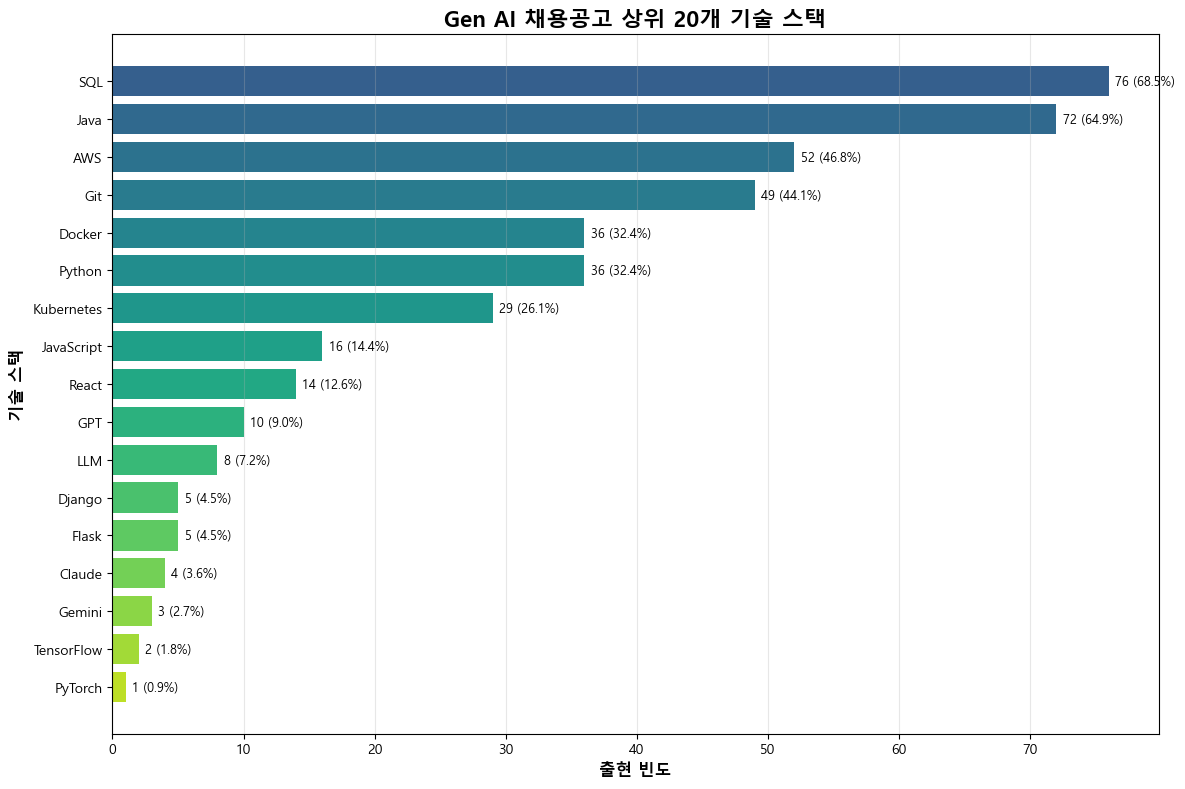


[기술 스택 공출현 분석 (상위 15개)]


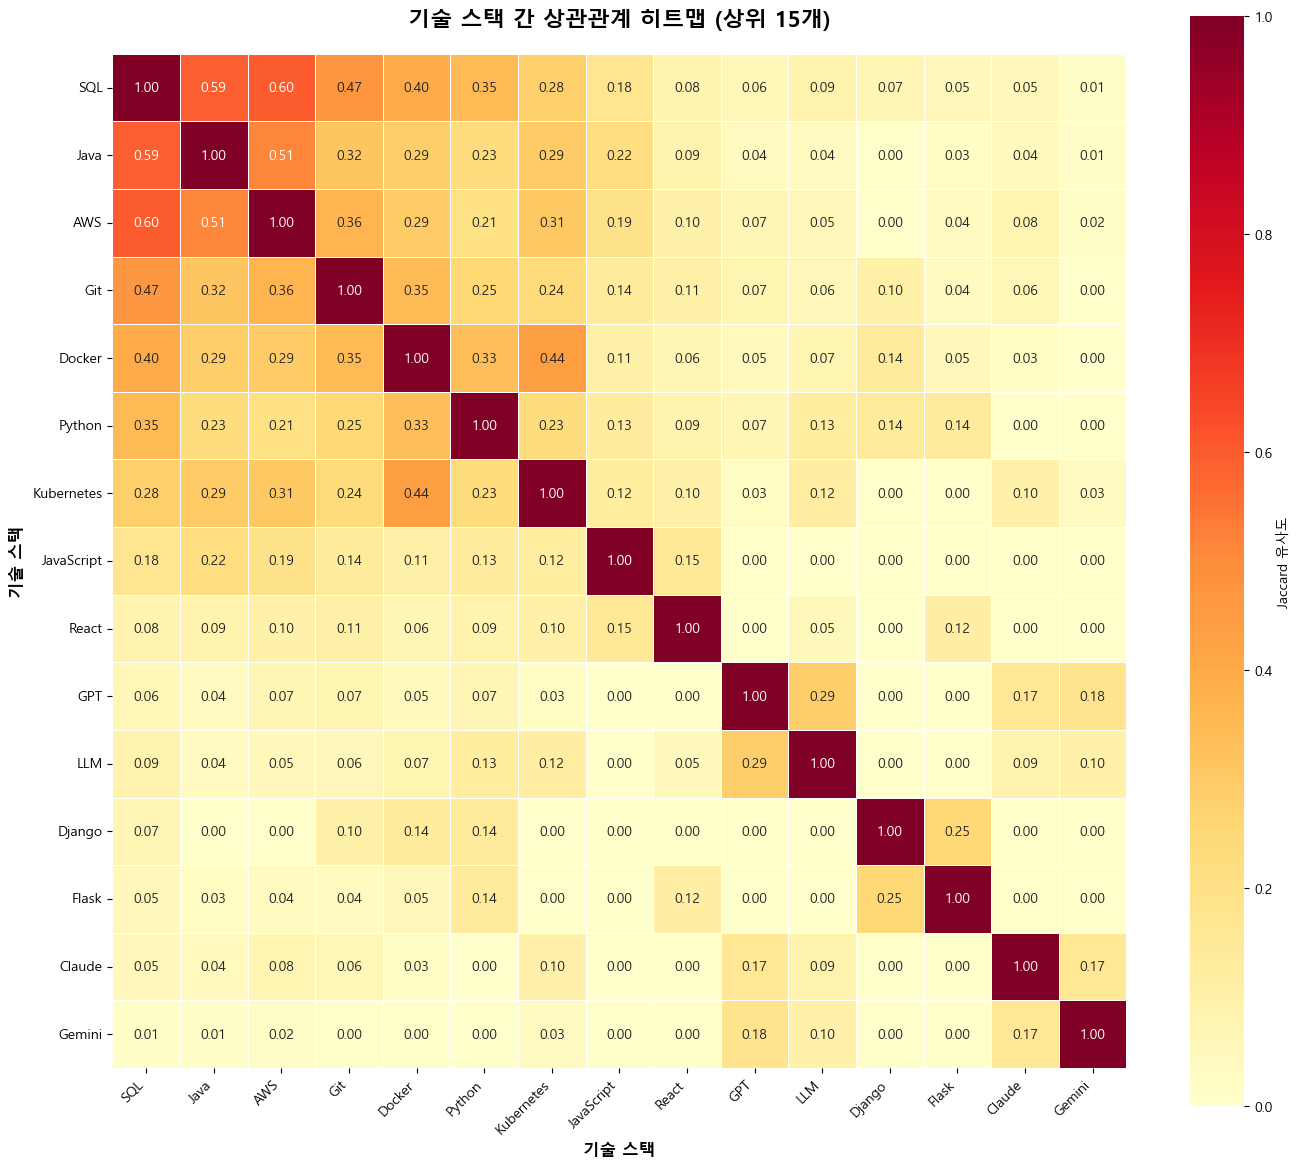


[강한 연관 규칙 (상위 20개)]
순위    기술1                  기술2                  함께    Support  Lift  
--------------------------------------------------------------------------------
1     GPT                  LLM                  4     0.036    5.55  
2     Django               Python               5     0.045    3.08  
3     Django               Docker               5     0.045    3.08  
4     Flask                Python               5     0.045    3.08  
5     Claude               Kubernetes           3     0.027    2.87  
6     Django               Git                  5     0.045    2.27  
7     AWS                  Claude               4     0.036    2.13  
8     Docker               Kubernetes           20    0.180    2.13  
9     JavaScript           React                4     0.036    1.98  
10    LLM                  Python               5     0.045    1.93  
11    Kubernetes           LLM                  4     0.036    1.91  
12    Claude               Git                  3     0.02

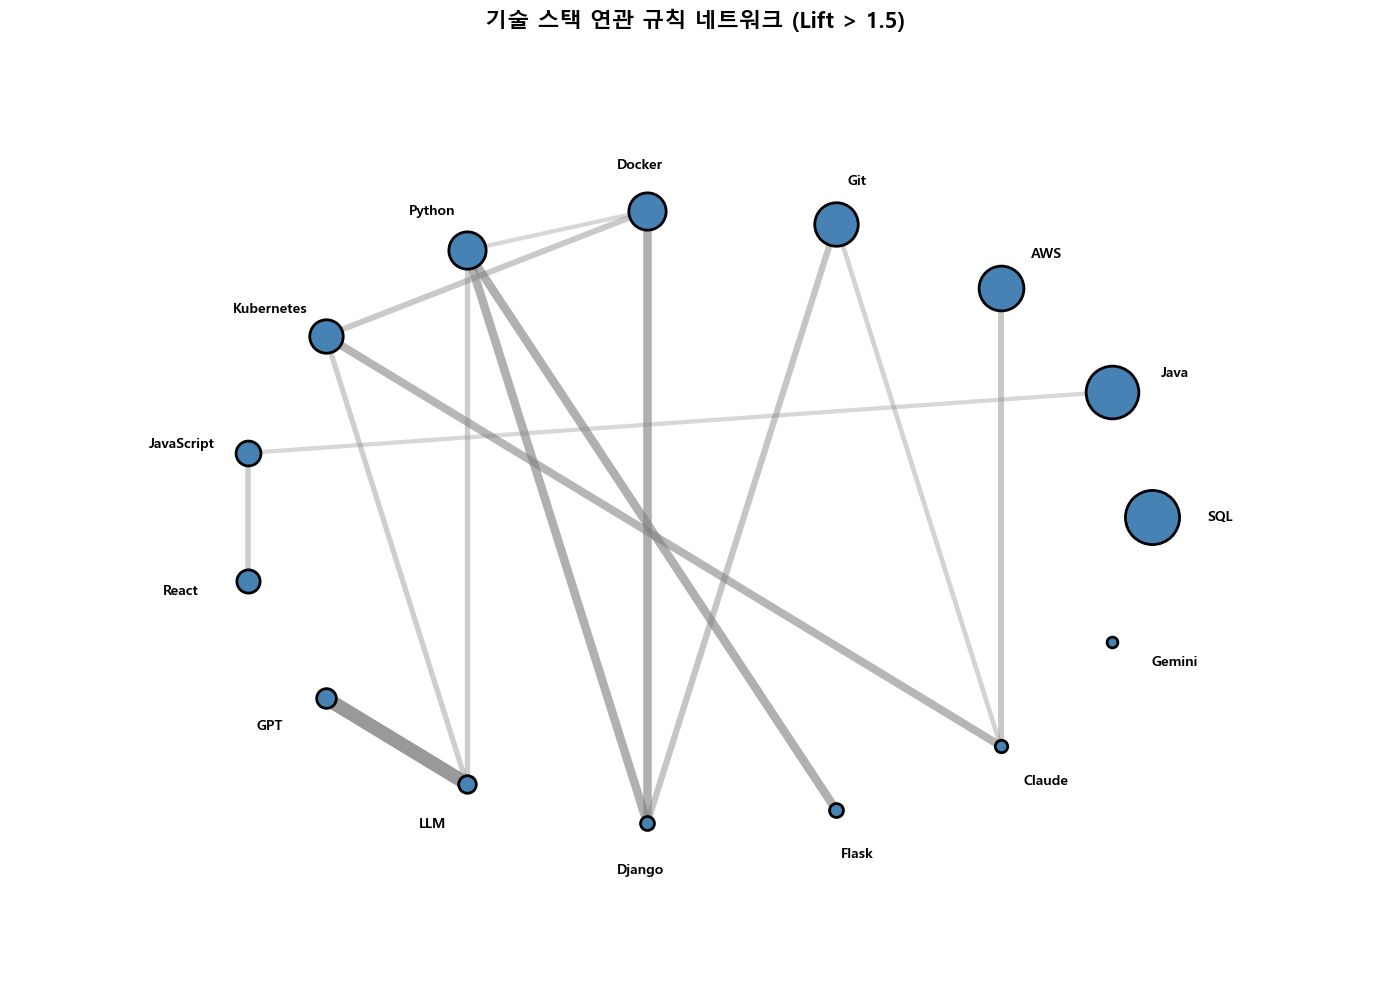


완료
- tech_stack_frequency.png
- tech_correlation_heatmap.png
- tech_association_network.png
- tech_stack_frequency.csv
- tech_correlation_matrix.csv
- tech_association_rules.csv


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
file_path = r"C:\Users\pc\saramin_detailed_20251213_033040.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')
print(f"데이터: {len(df)}개")

df['combined_text'] = df['Gen_AI 툴'].fillna('') + ' ' + df['Foundation 툴'].fillna('')
df = df[df['combined_text'].str.strip() != ''].reset_index(drop=True)
print(f"유효: {len(df)}개\n")

# 주요 기술 스택 정의 (Gen AI 관련)
tech_stacks = [
    'Python', 'PyTorch', 'TensorFlow', 'Keras', 'Scikit-learn', 'scikit',
    'GPT', 'ChatGPT', 'LLM', 'Transformer', 'BERT',
    'Langchain', 'LangChain', 'RAG',
    'OpenAI', 'Claude', 'Gemini', 'Anthropic',
    'Hugging Face', 'HuggingFace',
    'Docker', 'Kubernetes', 'AWS', 'Azure', 'GCP',
    'FastAPI', 'Flask', 'Django',
    'Vector DB', 'Pinecone', 'Chroma', 'Weaviate',
    'Pandas', 'NumPy', 'Matplotlib',
    'Git', 'GitHub', 'GitLab',
    'SQL', 'MongoDB', 'PostgreSQL', 'MySQL',
    'Java', 'JavaScript', 'TypeScript', 'React', 'Node.js',
    'Spark', 'Hadoop', 'Kafka',
    'MLflow', 'Weights & Biases', 'WandB',
    'Jupyter', 'Colab'
]

# 텍스트에서 기술 스택 추출
def extract_tech_stacks(text):
    found_techs = set()
    text_lower = text.lower()
    
    for tech in tech_stacks:
        if tech.lower() in text_lower:
            # 유사 기술 통합 (예: Langchain, LangChain)
            if tech.lower() in ['langchain', 'lang chain']:
                found_techs.add('LangChain')
            elif tech.lower() in ['hugging face', 'huggingface']:
                found_techs.add('HuggingFace')
            elif tech.lower() in ['scikit', 'scikit-learn']:
                found_techs.add('Scikit-learn')
            elif tech.lower() in ['chatgpt', 'gpt']:
                found_techs.add('GPT')
            elif tech.lower() in ['wandb', 'weights & biases']:
                found_techs.add('Weights&Biases')
            else:
                found_techs.add(tech)
    
    return list(found_techs)

df['tech_stacks'] = df['combined_text'].apply(extract_tech_stacks)

# 기술 스택이 있는 데이터만 필터링
df_tech = df[df['tech_stacks'].apply(len) > 0].reset_index(drop=True)
print(f"기술 스택 포함 데이터: {len(df_tech)}개\n")

# 기술 스택 빈도 분석
all_techs = []
for techs in df_tech['tech_stacks']:
    all_techs.extend(techs)

tech_counter = Counter(all_techs)
top_20_techs = tech_counter.most_common(20)

print("[상위 20개 기술 스택]")
for i, (tech, count) in enumerate(top_20_techs, 1):
    print(f"{i:2d}. {tech:20s} : {count:3d}회 ({count/len(df_tech)*100:.1f}%)")

# 기술 스택 빈도 차트
plt.figure(figsize=(12, 8))
techs = [tech for tech, _ in top_20_techs]
counts = [count for _, count in top_20_techs]

bars = plt.barh(range(len(techs)), counts, 
                color=plt.cm.viridis(np.linspace(0.3, 0.9, len(techs))))
plt.yticks(range(len(techs)), techs)
plt.xlabel('출현 빈도', fontsize=12, fontweight='bold')
plt.ylabel('기술 스택', fontsize=12, fontweight='bold')
plt.title('Gen AI 채용공고 상위 20개 기술 스택', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

for i, (bar, value) in enumerate(zip(bars, counts)):
    plt.text(value + 0.5, i, f'{value} ({value/len(df_tech)*100:.1f}%)', 
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('tech_stack_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

# 상위 N개 기술 스택만 사용 (상관관계 분석용)
top_n = 15
top_techs_list = [tech for tech, _ in tech_counter.most_common(top_n)]

# 기술 스택 공출현 행렬 생성
cooccurrence_matrix = pd.DataFrame(0, index=top_techs_list, columns=top_techs_list)

for techs in df_tech['tech_stacks']:
    techs_in_top = [t for t in techs if t in top_techs_list]
    
    # 같은 공고 내 기술 스택 쌍의 공출현 카운트
    for tech1, tech2 in combinations(techs_in_top, 2):
        cooccurrence_matrix.loc[tech1, tech2] += 1
        cooccurrence_matrix.loc[tech2, tech1] += 1

print(f"\n[기술 스택 공출현 분석 (상위 {top_n}개)]")

# 상관관계 계산 (Jaccard 유사도)
correlation_matrix = pd.DataFrame(0.0, index=top_techs_list, columns=top_techs_list)

for tech1 in top_techs_list:
    for tech2 in top_techs_list:
        if tech1 == tech2:
            correlation_matrix.loc[tech1, tech2] = 1.0
        else:
            # tech1과 tech2가 함께 나타나는 횟수
            together = cooccurrence_matrix.loc[tech1, tech2]
            # tech1 또는 tech2가 나타나는 총 횟수
            tech1_count = tech_counter[tech1]
            tech2_count = tech_counter[tech2]
            union = tech1_count + tech2_count - together
            
            # Jaccard 유사도
            if union > 0:
                correlation_matrix.loc[tech1, tech2] = together / union

# 상관관계 히트맵
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={'label': 'Jaccard 유사도'})
plt.title(f'기술 스택 간 상관관계 히트맵 (상위 {top_n}개)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('기술 스택', fontsize=12, fontweight='bold')
plt.ylabel('기술 스택', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('tech_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 강한 연관 규칙 추출
print("\n[강한 연관 규칙 (상위 20개)]")
associations = []

for tech1 in top_techs_list:
    for tech2 in top_techs_list:
        if tech1 < tech2:  # 중복 방지
            together = cooccurrence_matrix.loc[tech1, tech2]
            if together >= 3:  # 최소 3번 이상 함께 출현
                tech1_count = tech_counter[tech1]
                tech2_count = tech_counter[tech2]
                
                # Support: 함께 나타나는 비율
                support = together / len(df_tech)
                
                # Confidence: tech1 -> tech2
                confidence1 = together / tech1_count if tech1_count > 0 else 0
                # Confidence: tech2 -> tech1
                confidence2 = together / tech2_count if tech2_count > 0 else 0
                
                # Lift
                lift = (together / len(df_tech)) / ((tech1_count / len(df_tech)) * (tech2_count / len(df_tech)))
                
                associations.append({
                    'tech1': tech1,
                    'tech2': tech2,
                    'together': together,
                    'support': support,
                    'confidence_1_to_2': confidence1,
                    'confidence_2_to_1': confidence2,
                    'lift': lift
                })

# Lift 기준 정렬
associations_df = pd.DataFrame(associations)
associations_df = associations_df.sort_values('lift', ascending=False).reset_index(drop=True)

print(f"{'순위':<5} {'기술1':<20} {'기술2':<20} {'함께':<5} {'Support':<8} {'Lift':<6}")
print("-" * 80)
for i, row in associations_df.head(20).iterrows():
    print(f"{i+1:<5} {row['tech1']:<20} {row['tech2']:<20} {row['together']:<5.0f} {row['support']:<8.3f} {row['lift']:<6.2f}")

# 네트워크 시각화 (상위 연관 규칙)
plt.figure(figsize=(14, 10))

# 강한 연관 규칙만 필터링 (Lift > 1.5)
strong_associations = associations_df[associations_df['lift'] > 1.5].head(30)

# 노드 위치 계산 (원형 배치)
n_techs = len(top_techs_list)
angles = np.linspace(0, 2*np.pi, n_techs, endpoint=False)
tech_positions = {tech: (np.cos(angle), np.sin(angle)) 
                  for tech, angle in zip(top_techs_list, angles)}

# 엣지 그리기
for _, row in strong_associations.iterrows():
    pos1 = tech_positions[row['tech1']]
    pos2 = tech_positions[row['tech2']]
    
    # Lift에 따른 선 두께
    linewidth = min(row['lift'] * 2, 10)
    alpha = min(row['lift'] / 5, 0.8)
    
    plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
             'gray', linewidth=linewidth, alpha=alpha, zorder=1)

# 노드 그리기
for tech in top_techs_list:
    pos = tech_positions[tech]
    size = tech_counter[tech] * 20
    plt.scatter(pos[0], pos[1], s=size, c='steelblue', 
                edgecolors='black', linewidth=2, zorder=2)
    plt.text(pos[0]*1.15, pos[1]*1.15, tech, 
             ha='center', va='center', fontsize=10, fontweight='bold')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axis('off')
plt.title('기술 스택 연관 규칙 네트워크 (Lift > 1.5)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('tech_association_network.png', dpi=300, bbox_inches='tight')
plt.show()

# 결과 저장
tech_freq_df = pd.DataFrame(top_20_techs, columns=['기술스택', '빈도'])
tech_freq_df['비율(%)'] = (tech_freq_df['빈도'] / len(df_tech) * 100).round(1)
tech_freq_df.to_csv('tech_stack_frequency.csv', index=False, encoding='utf-8-sig')

correlation_matrix.to_csv('tech_correlation_matrix.csv', encoding='utf-8-sig')

associations_df.to_csv('tech_association_rules.csv', index=False, encoding='utf-8-sig')

print("\n완료")
print("- tech_stack_frequency.png")
print("- tech_correlation_heatmap.png")
print("- tech_association_network.png")
print("- tech_stack_frequency.csv")
print("- tech_correlation_matrix.csv")
print("- tech_association_rules.csv")
